#Pre Working

Mount Google Drive

In [26]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [0]:
# from google.colab import drive
# drive.mount("./gdrive")
# !unzip "./gdrive/My Drive/Assignment 5 Dataset.zip" -d "./gdrive/My Drive/Assignment5"

Import Libraries

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import time
import os
import copy
from tqdm import tqdm

Import Datasets

In [0]:
COVID_DataSet = '/drive/My Drive/Assignment5/Assignment 5 Dataset'

In [30]:
#Define transforms for the training data and testing data
# 256
train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])


test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


#pass transform here-in
train_data = datasets.ImageFolder(COVID_DataSet + '/train', transform = train_transforms)
test_data = datasets.ImageFolder(COVID_DataSet + '/test', transform = test_transforms)
valid_data = datasets.ImageFolder(COVID_DataSet + '/validation', transform = valid_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size = 20, shuffle = True)
testloader = torch.utils.data.DataLoader(test_data, batch_size = 20, shuffle = True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size = 20, shuffle = True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


In [31]:
print(len(train_data))
print(len(test_data))
print(len(valid_data))

12000
1500
1500


###Custom Functions

In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

def plot_curve(epochLst, errorLst):
    plt.plot(epochLst, errorLst, color='red', label='Learning Line')
    plt.legend()
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.show()

Image Show

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


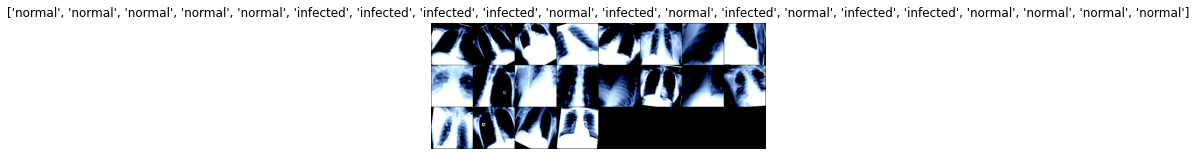

In [10]:
# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

#Task 1: Load pretrained CNN model and fine-tune FC Layers

###ResNet-18

In [0]:
# Load the pretrained model from pytorch [Pretrained on ImageNet]
T1_ResNet18_Model = models.resnet18(pretrained=True)
#print(T1ResNet18)
#print('Output Layer of RESNET-18 : ', T1ResNet18.fc.out_features)

In [0]:
# Remove last layer FC Layer

T1_ResNet18_Modules = list(T1_ResNet18_Model.children())[:-1]      # delete the last fc layer.
T1_ResNet18_Feature = nn.Sequential(*T1_ResNet18_Modules)

#print(T1ResNet18Feature)

#T1num_features = T1ResNet18.classifier[6].in_features
#T1features = list(T1ResNet18.classifier.children())[:-1] # Remove last layer
#print(T1features)

#T1features = T1ResNet18.Sequential(*list(T1ResNet18.classifier.children())[:-1])

In [0]:
# Freeze training for all layers
for param in T1_ResNet18_Model.parameters():
    param.require_grad = False

In [0]:
# Adding New Layer (FC - Layer)

# Input:25088                     Output:(Last 2 Digits * 10)+100
# Input:(Last 2 Digits * 10)+100  Output:Len(Class) = 2

T1_ResNet18_Modules.extend([nn.Linear(25088, (40 * 10) + 100)])
T1_ResNet18_Modules.extend([nn.Linear((40 * 10) + 100, len(class_names))])

In [15]:
# Update CNN after adding 2 FC Layers

T1_ResNet18_Model.classifier = nn.Sequential(*T1_ResNet18_Modules)

print(T1_ResNet18_Model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
# Loss Function and Optimizer

T1_ResNet18_Epochs = 10
T1_ResNet18_LearningRate = 0.001
T1_ResNet18_Momentum = 0.9
T1_ResNet18_Criterion = nn.CrossEntropyLoss()

T1_ResNet18_Optimizer = optim.SGD(T1_ResNet18_Model.parameters(), lr = T1_ResNet18_LearningRate, momentum = T1_ResNet18_Momentum)

Training

Streaming output truncated to the last 5000 lines.








Train Epoch: 0 [7000/12000 (58%)]	Loss: 0.337713: : 350it [09:04,  1.20s/it]









Train Epoch: 0 [7000/12000 (58%)]	Loss: 0.337713: : 351it [09:04,  1.90s/it]









Train Epoch: 0 [7020/12000 (58%)]	Loss: 0.285416: : 351it [09:06,  1.90s/it]









Train Epoch: 0 [7020/12000 (58%)]	Loss: 0.285416: : 352it [09:06,  1.85s/it]









Train Epoch: 0 [7040/12000 (59%)]	Loss: 0.312607: : 352it [09:06,  1.85s/it]









Train Epoch: 0 [7040/12000 (59%)]	Loss: 0.312607: : 353it [09:06,  1.58s/it]









Train Epoch: 0 [7060/12000 (59%)]	Loss: 0.749807: : 353it [09:08,  1.58s/it]









Train Epoch: 0 [7060/12000 (59%)]	Loss: 0.749807: : 354it [09:08,  1.69s/it]









Train Epoch: 0 [7080/12000 (59%)]	Loss: 0.476996: : 354it [09:09,  1.69s/it]









Train Epoch: 0 [7080/12000 (59%)]	Loss: 0.476996: : 355it [09:09,  1.34s/it]









Train Epoch: 0 [7100/12000 (59%)]	Loss: 0.302123: : 355it [09:11,  1.34s/it]






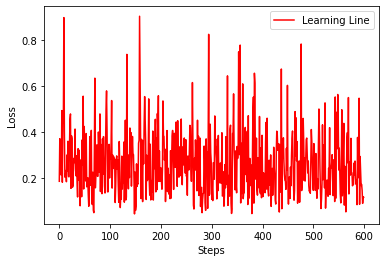

Streaming output truncated to the last 5000 lines.








Train Epoch: 1 [7000/12000 (58%)]	Loss: 0.173197: : 350it [02:58,  1.86it/s]









Train Epoch: 1 [7000/12000 (58%)]	Loss: 0.173197: : 351it [02:58,  1.90it/s]









Train Epoch: 1 [7020/12000 (58%)]	Loss: 0.412433: : 351it [02:59,  1.90it/s]









Train Epoch: 1 [7020/12000 (58%)]	Loss: 0.412433: : 352it [02:59,  1.93it/s]









Train Epoch: 1 [7040/12000 (59%)]	Loss: 0.425084: : 352it [02:59,  1.93it/s]









Train Epoch: 1 [7040/12000 (59%)]	Loss: 0.425084: : 353it [02:59,  1.94it/s]









Train Epoch: 1 [7060/12000 (59%)]	Loss: 0.395743: : 353it [03:00,  1.94it/s]









Train Epoch: 1 [7060/12000 (59%)]	Loss: 0.395743: : 354it [03:00,  1.95it/s]









Train Epoch: 1 [7080/12000 (59%)]	Loss: 0.312011: : 354it [03:00,  1.95it/s]









Train Epoch: 1 [7080/12000 (59%)]	Loss: 0.312011: : 355it [03:00,  1.95it/s]









Train Epoch: 1 [7100/12000 (59%)]	Loss: 0.280212: : 355it [03:01,  1.95it/s]






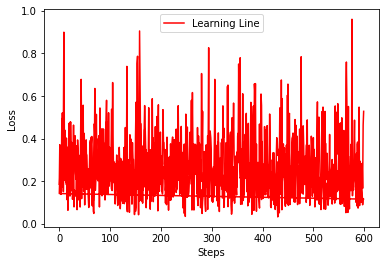

Streaming output truncated to the last 5000 lines.








Train Epoch: 2 [7000/12000 (58%)]	Loss: 0.245764: : 350it [02:56,  1.97it/s]









Train Epoch: 2 [7000/12000 (58%)]	Loss: 0.245764: : 351it [02:56,  1.95it/s]









Train Epoch: 2 [7020/12000 (58%)]	Loss: 0.535878: : 351it [02:56,  1.95it/s]









Train Epoch: 2 [7020/12000 (58%)]	Loss: 0.535878: : 352it [02:56,  1.96it/s]









Train Epoch: 2 [7040/12000 (59%)]	Loss: 0.096292: : 352it [02:57,  1.96it/s]









Train Epoch: 2 [7040/12000 (59%)]	Loss: 0.096292: : 353it [02:57,  1.98it/s]









Train Epoch: 2 [7060/12000 (59%)]	Loss: 0.096015: : 353it [02:57,  1.98it/s]









Train Epoch: 2 [7060/12000 (59%)]	Loss: 0.096015: : 354it [02:57,  1.97it/s]









Train Epoch: 2 [7080/12000 (59%)]	Loss: 0.165536: : 354it [02:58,  1.97it/s]









Train Epoch: 2 [7080/12000 (59%)]	Loss: 0.165536: : 355it [02:58,  1.98it/s]









Train Epoch: 2 [7100/12000 (59%)]	Loss: 0.107062: : 355it [02:58,  1.98it/s]






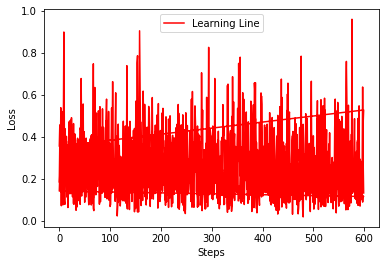

Streaming output truncated to the last 5000 lines.








Train Epoch: 3 [7000/12000 (58%)]	Loss: 0.355472: : 350it [02:57,  1.92it/s]









Train Epoch: 3 [7000/12000 (58%)]	Loss: 0.355472: : 351it [02:57,  1.95it/s]









Train Epoch: 3 [7020/12000 (58%)]	Loss: 0.318751: : 351it [02:57,  1.95it/s]









Train Epoch: 3 [7020/12000 (58%)]	Loss: 0.318751: : 352it [02:57,  1.94it/s]









Train Epoch: 3 [7040/12000 (59%)]	Loss: 0.274295: : 352it [02:58,  1.94it/s]









Train Epoch: 3 [7040/12000 (59%)]	Loss: 0.274295: : 353it [02:58,  1.95it/s]









Train Epoch: 3 [7060/12000 (59%)]	Loss: 0.413157: : 353it [02:58,  1.95it/s]









Train Epoch: 3 [7060/12000 (59%)]	Loss: 0.413157: : 354it [02:58,  1.96it/s]









Train Epoch: 3 [7080/12000 (59%)]	Loss: 0.308877: : 354it [02:59,  1.96it/s]









Train Epoch: 3 [7080/12000 (59%)]	Loss: 0.308877: : 355it [02:59,  1.95it/s]









Train Epoch: 3 [7100/12000 (59%)]	Loss: 0.356881: : 355it [02:59,  1.95it/s]






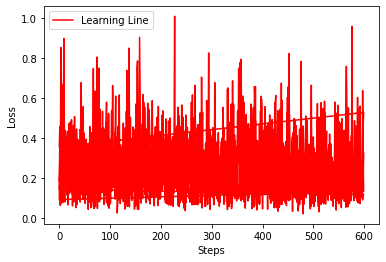

Streaming output truncated to the last 5000 lines.








Train Epoch: 4 [7000/12000 (58%)]	Loss: 0.041126: : 350it [02:57,  1.94it/s]









Train Epoch: 4 [7000/12000 (58%)]	Loss: 0.041126: : 351it [02:57,  1.94it/s]









Train Epoch: 4 [7020/12000 (58%)]	Loss: 0.165168: : 351it [02:58,  1.94it/s]









Train Epoch: 4 [7020/12000 (58%)]	Loss: 0.165168: : 352it [02:58,  1.94it/s]









Train Epoch: 4 [7040/12000 (59%)]	Loss: 0.507452: : 352it [02:58,  1.94it/s]









Train Epoch: 4 [7040/12000 (59%)]	Loss: 0.507452: : 353it [02:58,  1.95it/s]









Train Epoch: 4 [7060/12000 (59%)]	Loss: 0.191311: : 353it [02:59,  1.95it/s]









Train Epoch: 4 [7060/12000 (59%)]	Loss: 0.191311: : 354it [02:59,  1.95it/s]









Train Epoch: 4 [7080/12000 (59%)]	Loss: 0.372323: : 354it [02:59,  1.95it/s]









Train Epoch: 4 [7080/12000 (59%)]	Loss: 0.372323: : 355it [02:59,  1.96it/s]









Train Epoch: 4 [7100/12000 (59%)]	Loss: 0.817254: : 355it [03:00,  1.96it/s]






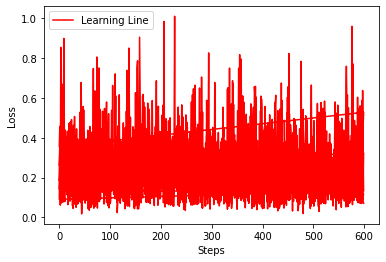

Streaming output truncated to the last 5000 lines.








Train Epoch: 5 [7000/12000 (58%)]	Loss: 0.215103: : 350it [02:57,  1.93it/s]









Train Epoch: 5 [7000/12000 (58%)]	Loss: 0.215103: : 351it [02:57,  1.92it/s]









Train Epoch: 5 [7020/12000 (58%)]	Loss: 0.126658: : 351it [02:58,  1.92it/s]









Train Epoch: 5 [7020/12000 (58%)]	Loss: 0.126658: : 352it [02:58,  1.92it/s]









Train Epoch: 5 [7040/12000 (59%)]	Loss: 0.219657: : 352it [02:58,  1.92it/s]









Train Epoch: 5 [7040/12000 (59%)]	Loss: 0.219657: : 353it [02:58,  1.72it/s]









Train Epoch: 5 [7060/12000 (59%)]	Loss: 0.114847: : 353it [02:59,  1.72it/s]









Train Epoch: 5 [7060/12000 (59%)]	Loss: 0.114847: : 354it [02:59,  1.78it/s]









Train Epoch: 5 [7080/12000 (59%)]	Loss: 0.309405: : 354it [02:59,  1.78it/s]









Train Epoch: 5 [7080/12000 (59%)]	Loss: 0.309405: : 355it [02:59,  1.83it/s]









Train Epoch: 5 [7100/12000 (59%)]	Loss: 0.136919: : 355it [03:00,  1.83it/s]






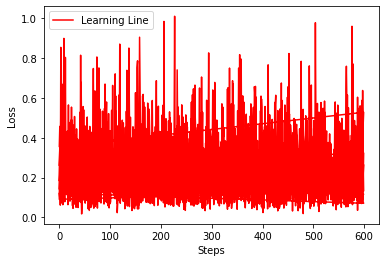

Streaming output truncated to the last 5000 lines.








Train Epoch: 6 [7000/12000 (58%)]	Loss: 0.214729: : 350it [03:00,  1.95it/s]









Train Epoch: 6 [7000/12000 (58%)]	Loss: 0.214729: : 351it [03:00,  1.96it/s]









Train Epoch: 6 [7020/12000 (58%)]	Loss: 0.127880: : 351it [03:00,  1.96it/s]









Train Epoch: 6 [7020/12000 (58%)]	Loss: 0.127880: : 352it [03:00,  1.96it/s]









Train Epoch: 6 [7040/12000 (59%)]	Loss: 0.219082: : 352it [03:01,  1.96it/s]









Train Epoch: 6 [7040/12000 (59%)]	Loss: 0.219082: : 353it [03:01,  1.96it/s]









Train Epoch: 6 [7060/12000 (59%)]	Loss: 0.333611: : 353it [03:01,  1.96it/s]









Train Epoch: 6 [7060/12000 (59%)]	Loss: 0.333611: : 354it [03:01,  1.96it/s]









Train Epoch: 6 [7080/12000 (59%)]	Loss: 0.154963: : 354it [03:02,  1.96it/s]









Train Epoch: 6 [7080/12000 (59%)]	Loss: 0.154963: : 355it [03:02,  1.95it/s]









Train Epoch: 6 [7100/12000 (59%)]	Loss: 0.281191: : 355it [03:02,  1.95it/s]






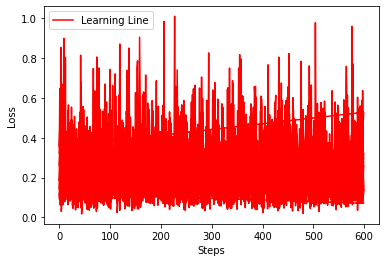

Streaming output truncated to the last 5000 lines.








Train Epoch: 7 [7000/12000 (58%)]	Loss: 0.064985: : 350it [02:55,  2.04it/s]









Train Epoch: 7 [7000/12000 (58%)]	Loss: 0.064985: : 351it [02:55,  2.03it/s]









Train Epoch: 7 [7020/12000 (58%)]	Loss: 0.083035: : 351it [02:55,  2.03it/s]









Train Epoch: 7 [7020/12000 (58%)]	Loss: 0.083035: : 352it [02:55,  2.02it/s]









Train Epoch: 7 [7040/12000 (59%)]	Loss: 0.111227: : 352it [02:56,  2.02it/s]









Train Epoch: 7 [7040/12000 (59%)]	Loss: 0.111227: : 353it [02:56,  2.00it/s]









Train Epoch: 7 [7060/12000 (59%)]	Loss: 0.108756: : 353it [02:56,  2.00it/s]









Train Epoch: 7 [7060/12000 (59%)]	Loss: 0.108756: : 354it [02:56,  2.03it/s]









Train Epoch: 7 [7080/12000 (59%)]	Loss: 0.479308: : 354it [02:57,  2.03it/s]









Train Epoch: 7 [7080/12000 (59%)]	Loss: 0.479308: : 355it [02:57,  2.00it/s]









Train Epoch: 7 [7100/12000 (59%)]	Loss: 0.149083: : 355it [02:57,  2.00it/s]






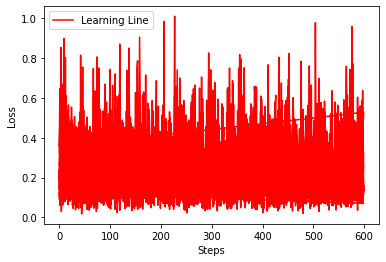

Streaming output truncated to the last 5000 lines.








Train Epoch: 8 [7000/12000 (58%)]	Loss: 0.159695: : 350it [02:55,  1.93it/s]









Train Epoch: 8 [7000/12000 (58%)]	Loss: 0.159695: : 351it [02:55,  1.93it/s]









Train Epoch: 8 [7020/12000 (58%)]	Loss: 0.071024: : 351it [02:55,  1.93it/s]









Train Epoch: 8 [7020/12000 (58%)]	Loss: 0.071024: : 352it [02:55,  1.93it/s]









Train Epoch: 8 [7040/12000 (59%)]	Loss: 0.167191: : 352it [02:56,  1.93it/s]









Train Epoch: 8 [7040/12000 (59%)]	Loss: 0.167191: : 353it [02:56,  1.94it/s]









Train Epoch: 8 [7060/12000 (59%)]	Loss: 0.118718: : 353it [02:56,  1.94it/s]









Train Epoch: 8 [7060/12000 (59%)]	Loss: 0.118718: : 354it [02:56,  1.96it/s]









Train Epoch: 8 [7080/12000 (59%)]	Loss: 0.154197: : 354it [02:57,  1.96it/s]









Train Epoch: 8 [7080/12000 (59%)]	Loss: 0.154197: : 355it [02:57,  1.96it/s]









Train Epoch: 8 [7100/12000 (59%)]	Loss: 0.254258: : 355it [02:57,  1.96it/s]






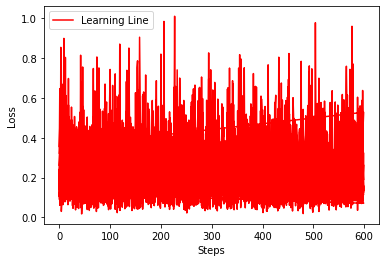

Streaming output truncated to the last 5000 lines.








Train Epoch: 9 [7000/12000 (58%)]	Loss: 0.232936: : 350it [02:56,  1.94it/s]









Train Epoch: 9 [7000/12000 (58%)]	Loss: 0.232936: : 351it [02:56,  1.78it/s]









Train Epoch: 9 [7020/12000 (58%)]	Loss: 0.212536: : 351it [02:56,  1.78it/s]









Train Epoch: 9 [7020/12000 (58%)]	Loss: 0.212536: : 352it [02:56,  1.81it/s]









Train Epoch: 9 [7040/12000 (59%)]	Loss: 0.122787: : 352it [02:57,  1.81it/s]









Train Epoch: 9 [7040/12000 (59%)]	Loss: 0.122787: : 353it [02:57,  1.84it/s]









Train Epoch: 9 [7060/12000 (59%)]	Loss: 0.104079: : 353it [02:57,  1.84it/s]









Train Epoch: 9 [7060/12000 (59%)]	Loss: 0.104079: : 354it [02:57,  1.86it/s]









Train Epoch: 9 [7080/12000 (59%)]	Loss: 0.137758: : 354it [02:58,  1.86it/s]









Train Epoch: 9 [7080/12000 (59%)]	Loss: 0.137758: : 355it [02:58,  1.88it/s]









Train Epoch: 9 [7100/12000 (59%)]	Loss: 0.065271: : 355it [02:58,  1.88it/s]






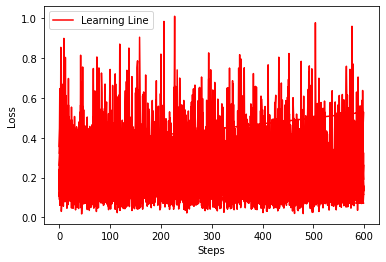

Finished Training


In [93]:
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
T1_ResNet18_Model.to(device)

T1_ResNet18_Model.train()

T1_ResNet18_lossLst = list()
T1_ResNet18_epochLst = list()
for epoch in range(T1_ResNet18_Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        T1_ResNet18_Optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = T1_ResNet18_Model(inputs)                           #----> forward pass
        loss = T1_ResNet18_Criterion(outputs, labels)                 #----> compute loss
        loss.backward()                                               #----> backward pass
        T1_ResNet18_Optimizer.step()                                  #----> weights update

        # print statistics
        running_loss += loss.item()

        pbar.set_description('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader), loss.item()))
        
        T1_ResNet18_lossLst.append(loss.item())
        T1_ResNet18_epochLst.append(i)
        
    plot_curve(T1_ResNet18_epochLst,T1_ResNet18_lossLst)
    torch.save(T1_ResNet18_Model.state_dict(), 'res18_FC_Only.pth')

print('Finished Training')

Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


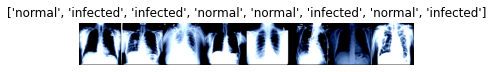

In [61]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

Prediction

In [94]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = T1_ResNet18_Model(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: \t', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: \t', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images)))) 

Predicted: 	 infected normal infected normal
Ground Truth: 	 normal normal normal normal


In [98]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = T1_ResNet18_Model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the '+ str(len(test_data)) +' test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 1500 test images: 96 %


tensor([[591.,  24.],
        [ 27., 858.]])


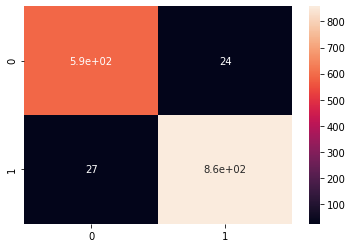

In [99]:
# Confusion Matrix of TEST 

confusion_matrix = torch.zeros(2, 2)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = T1_ResNet18_Model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
              
print(confusion_matrix)
sn.heatmap(confusion_matrix, annot=True)

On Validation Data

In [100]:
correct = 0
total = 0
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = T1_ResNet18_Model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the '+ str(len(valid_data)) +' validation images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 1500 validation images: 90 %


tensor([[577.,  38.],
        [ 91., 794.]])


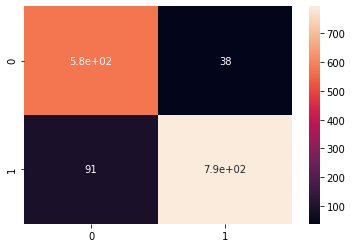

In [101]:
# Confusion Matrix of VALID 

confusion_matrix = torch.zeros(2, 2)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(validloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = T1_ResNet18_Model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
              
print(confusion_matrix)
sn.heatmap(confusion_matrix, annot=True)

###VGG-16

In [12]:
# Load the pretrained model from pytorch
T1_VGG16_Model = models.vgg16(pretrained=True)
#print(T1_VGG16_Model)
#print('Output Layer of VGG-16 : ', T1_VGG16_Model.classifier[6].out_features) 

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [13]:
# Remove last layer
T1_VGG16_Features = list(T1_VGG16_Model.classifier.children())[:-1] # Remove last layer
print(T1_VGG16_Features)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False)]


In [0]:
# Freeze training for all layers
for param in T1_VGG16_Model.features.parameters():
    param.require_grad = False

In [0]:
# Adding New Layer (Linear - FC Layer)

# Input:25088                     Output:(Last 2 Digits * 10)+100
# Input:(Last 2 Digits * 10)+100  Output:Len(Class) = 2

T1_VGG16_Features.extend([nn.Linear(T1_VGG16_Model.classifier[6].in_features, (40 * 10) + 100)])
T1_VGG16_Features.extend([nn.Linear((40 * 10) + 100, len(class_names))])

In [16]:
T1_VGG16_Model.classifier = nn.Sequential(*T1_VGG16_Features)
print(T1_VGG16_Model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# Loss Function and Optimizer

T1_Vgg16_Epochs = 10 #10
T1_Vgg16_LearningRate = 0.001 # 0.001
T1_Vgg16_Momentum = 0.9
T1_Vgg16_Criterion = nn.CrossEntropyLoss()

T1_Vgg16_Optimizer = optim.SGD(T1_VGG16_Model.parameters(), lr = T1_Vgg16_LearningRate, momentum = T1_Vgg16_Momentum)

Training

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
T1_VGG16_Model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Streaming output truncated to the last 5000 lines.








Train Epoch: 0 [7000/12000 (58%)]	Loss: 0.124662: : 350it [11:20,  1.99s/it]









Train Epoch: 0 [7000/12000 (58%)]	Loss: 0.124662: : 351it [11:20,  1.88s/it]









Train Epoch: 0 [7020/12000 (58%)]	Loss: 0.448268: : 351it [11:21,  1.88s/it]









Train Epoch: 0 [7020/12000 (58%)]	Loss: 0.448268: : 352it [11:21,  1.67s/it]









Train Epoch: 0 [7040/12000 (59%)]	Loss: 0.516030: : 352it [11:22,  1.67s/it]









Train Epoch: 0 [7040/12000 (59%)]	Loss: 0.516030: : 353it [11:22,  1.66s/it]









Train Epoch: 0 [7060/12000 (59%)]	Loss: 0.233887: : 353it [11:24,  1.66s/it]









Train Epoch: 0 [7060/12000 (59%)]	Loss: 0.233887: : 354it [11:24,  1.50s/it]









Train Epoch: 0 [7080/12000 (59%)]	Loss: 0.093771: : 354it [11:26,  1.50s/it]









Train Epoch: 0 [7080/12000 (59%)]	Loss: 0.093771: : 355it [11:26,  1.73s/it]









Train Epoch: 0 [7100/12000 (59%)]	Loss: 0.199400: : 355it [11:29,  1.73s/it]






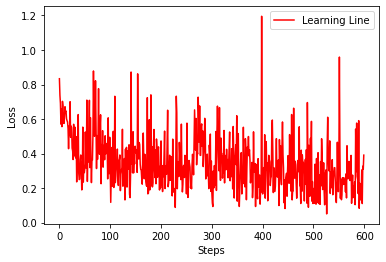

Streaming output truncated to the last 5000 lines.








Train Epoch: 1 [7000/12000 (58%)]	Loss: 0.096312: : 350it [05:03,  1.11it/s]









Train Epoch: 1 [7000/12000 (58%)]	Loss: 0.096312: : 351it [05:03,  1.13it/s]









Train Epoch: 1 [7020/12000 (58%)]	Loss: 0.219196: : 351it [05:04,  1.13it/s]









Train Epoch: 1 [7020/12000 (58%)]	Loss: 0.219196: : 352it [05:04,  1.13it/s]









Train Epoch: 1 [7040/12000 (59%)]	Loss: 0.487280: : 352it [05:05,  1.13it/s]









Train Epoch: 1 [7040/12000 (59%)]	Loss: 0.487280: : 353it [05:05,  1.13it/s]









Train Epoch: 1 [7060/12000 (59%)]	Loss: 0.316096: : 353it [05:06,  1.13it/s]









Train Epoch: 1 [7060/12000 (59%)]	Loss: 0.316096: : 354it [05:06,  1.14it/s]









Train Epoch: 1 [7080/12000 (59%)]	Loss: 0.250040: : 354it [05:06,  1.14it/s]









Train Epoch: 1 [7080/12000 (59%)]	Loss: 0.250040: : 355it [05:06,  1.14it/s]









Train Epoch: 1 [7100/12000 (59%)]	Loss: 0.081415: : 355it [05:07,  1.14it/s]






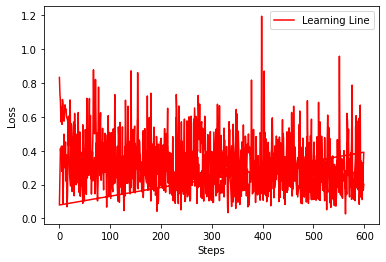

Streaming output truncated to the last 5000 lines.








Train Epoch: 2 [7000/12000 (58%)]	Loss: 0.485095: : 350it [04:58,  1.15it/s]









Train Epoch: 2 [7000/12000 (58%)]	Loss: 0.485095: : 351it [04:58,  1.16it/s]









Train Epoch: 2 [7020/12000 (58%)]	Loss: 0.161440: : 351it [04:58,  1.16it/s]









Train Epoch: 2 [7020/12000 (58%)]	Loss: 0.161440: : 352it [04:58,  1.18it/s]









Train Epoch: 2 [7040/12000 (59%)]	Loss: 0.161751: : 352it [04:59,  1.18it/s]









Train Epoch: 2 [7040/12000 (59%)]	Loss: 0.161751: : 353it [04:59,  1.16it/s]









Train Epoch: 2 [7060/12000 (59%)]	Loss: 0.029573: : 353it [05:00,  1.16it/s]









Train Epoch: 2 [7060/12000 (59%)]	Loss: 0.029573: : 354it [05:00,  1.15it/s]









Train Epoch: 2 [7080/12000 (59%)]	Loss: 0.280104: : 354it [05:01,  1.15it/s]









Train Epoch: 2 [7080/12000 (59%)]	Loss: 0.280104: : 355it [05:01,  1.16it/s]









Train Epoch: 2 [7100/12000 (59%)]	Loss: 0.132548: : 355it [05:02,  1.16it/s]






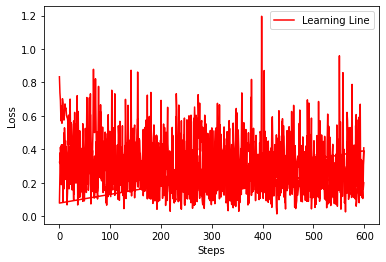

Streaming output truncated to the last 5000 lines.








Train Epoch: 3 [7000/12000 (58%)]	Loss: 0.253351: : 350it [04:57,  1.14it/s]









Train Epoch: 3 [7000/12000 (58%)]	Loss: 0.253351: : 351it [04:57,  1.16it/s]









Train Epoch: 3 [7020/12000 (58%)]	Loss: 0.236114: : 351it [04:58,  1.16it/s]









Train Epoch: 3 [7020/12000 (58%)]	Loss: 0.236114: : 352it [04:58,  1.13it/s]









Train Epoch: 3 [7040/12000 (59%)]	Loss: 0.353243: : 352it [04:59,  1.13it/s]









Train Epoch: 3 [7040/12000 (59%)]	Loss: 0.353243: : 353it [04:59,  1.15it/s]









Train Epoch: 3 [7060/12000 (59%)]	Loss: 0.391190: : 353it [05:00,  1.15it/s]









Train Epoch: 3 [7060/12000 (59%)]	Loss: 0.391190: : 354it [05:00,  1.14it/s]









Train Epoch: 3 [7080/12000 (59%)]	Loss: 0.230356: : 354it [05:01,  1.14it/s]









Train Epoch: 3 [7080/12000 (59%)]	Loss: 0.230356: : 355it [05:01,  1.14it/s]









Train Epoch: 3 [7100/12000 (59%)]	Loss: 0.429985: : 355it [05:01,  1.14it/s]






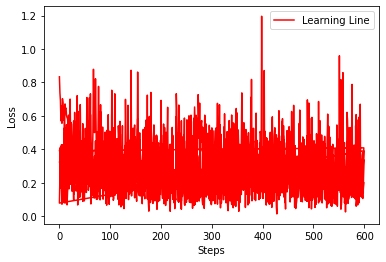

Streaming output truncated to the last 5000 lines.








Train Epoch: 4 [7000/12000 (58%)]	Loss: 0.286675: : 350it [05:02,  1.16it/s]









Train Epoch: 4 [7000/12000 (58%)]	Loss: 0.286675: : 351it [05:02,  1.10it/s]









Train Epoch: 4 [7020/12000 (58%)]	Loss: 0.108062: : 351it [05:02,  1.10it/s]









Train Epoch: 4 [7020/12000 (58%)]	Loss: 0.108062: : 352it [05:02,  1.12it/s]









Train Epoch: 4 [7040/12000 (59%)]	Loss: 0.340445: : 352it [05:03,  1.12it/s]









Train Epoch: 4 [7040/12000 (59%)]	Loss: 0.340445: : 353it [05:03,  1.13it/s]









Train Epoch: 4 [7060/12000 (59%)]	Loss: 0.215535: : 353it [05:04,  1.13it/s]









Train Epoch: 4 [7060/12000 (59%)]	Loss: 0.215535: : 354it [05:04,  1.13it/s]









Train Epoch: 4 [7080/12000 (59%)]	Loss: 0.199834: : 354it [05:05,  1.13it/s]









Train Epoch: 4 [7080/12000 (59%)]	Loss: 0.199834: : 355it [05:05,  1.14it/s]









Train Epoch: 4 [7100/12000 (59%)]	Loss: 0.165451: : 355it [05:06,  1.14it/s]






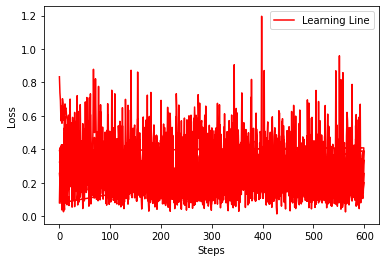

Streaming output truncated to the last 5000 lines.








Train Epoch: 5 [7000/12000 (58%)]	Loss: 0.187162: : 350it [05:04,  1.13it/s]









Train Epoch: 5 [7000/12000 (58%)]	Loss: 0.187162: : 351it [05:04,  1.14it/s]









Train Epoch: 5 [7020/12000 (58%)]	Loss: 0.741750: : 351it [05:05,  1.14it/s]









Train Epoch: 5 [7020/12000 (58%)]	Loss: 0.741750: : 352it [05:05,  1.13it/s]









Train Epoch: 5 [7040/12000 (59%)]	Loss: 0.156792: : 352it [05:06,  1.13it/s]









Train Epoch: 5 [7040/12000 (59%)]	Loss: 0.156792: : 353it [05:06,  1.14it/s]









Train Epoch: 5 [7060/12000 (59%)]	Loss: 0.189254: : 353it [05:07,  1.14it/s]









Train Epoch: 5 [7060/12000 (59%)]	Loss: 0.189254: : 354it [05:07,  1.15it/s]









Train Epoch: 5 [7080/12000 (59%)]	Loss: 0.153851: : 354it [05:08,  1.15it/s]









Train Epoch: 5 [7080/12000 (59%)]	Loss: 0.153851: : 355it [05:08,  1.15it/s]









Train Epoch: 5 [7100/12000 (59%)]	Loss: 0.235124: : 355it [05:09,  1.15it/s]






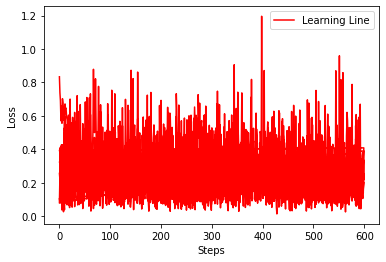

Streaming output truncated to the last 5000 lines.








Train Epoch: 6 [7000/12000 (58%)]	Loss: 0.230821: : 350it [04:58,  1.15it/s]









Train Epoch: 6 [7000/12000 (58%)]	Loss: 0.230821: : 351it [04:58,  1.15it/s]









Train Epoch: 6 [7020/12000 (58%)]	Loss: 0.118926: : 351it [04:59,  1.15it/s]









Train Epoch: 6 [7020/12000 (58%)]	Loss: 0.118926: : 352it [04:59,  1.15it/s]









Train Epoch: 6 [7040/12000 (59%)]	Loss: 0.171652: : 352it [05:00,  1.15it/s]









Train Epoch: 6 [7040/12000 (59%)]	Loss: 0.171652: : 353it [05:00,  1.15it/s]









Train Epoch: 6 [7060/12000 (59%)]	Loss: 0.311843: : 353it [05:00,  1.15it/s]









Train Epoch: 6 [7060/12000 (59%)]	Loss: 0.311843: : 354it [05:00,  1.15it/s]









Train Epoch: 6 [7080/12000 (59%)]	Loss: 0.209791: : 354it [05:01,  1.15it/s]









Train Epoch: 6 [7080/12000 (59%)]	Loss: 0.209791: : 355it [05:01,  1.13it/s]









Train Epoch: 6 [7100/12000 (59%)]	Loss: 0.231149: : 355it [05:02,  1.13it/s]






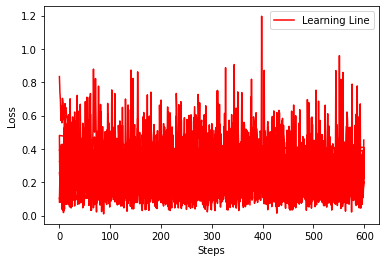

Streaming output truncated to the last 5000 lines.








Train Epoch: 7 [7000/12000 (58%)]	Loss: 0.407112: : 350it [04:58,  1.14it/s]









Train Epoch: 7 [7000/12000 (58%)]	Loss: 0.407112: : 351it [04:58,  1.15it/s]









Train Epoch: 7 [7020/12000 (58%)]	Loss: 0.139543: : 351it [04:58,  1.15it/s]









Train Epoch: 7 [7020/12000 (58%)]	Loss: 0.139543: : 352it [04:58,  1.17it/s]









Train Epoch: 7 [7040/12000 (59%)]	Loss: 0.204078: : 352it [04:59,  1.17it/s]









Train Epoch: 7 [7040/12000 (59%)]	Loss: 0.204078: : 353it [04:59,  1.17it/s]









Train Epoch: 7 [7060/12000 (59%)]	Loss: 0.072155: : 353it [05:00,  1.17it/s]









Train Epoch: 7 [7060/12000 (59%)]	Loss: 0.072155: : 354it [05:00,  1.17it/s]









Train Epoch: 7 [7080/12000 (59%)]	Loss: 0.121037: : 354it [05:01,  1.17it/s]









Train Epoch: 7 [7080/12000 (59%)]	Loss: 0.121037: : 355it [05:01,  1.17it/s]









Train Epoch: 7 [7100/12000 (59%)]	Loss: 0.211459: : 355it [05:02,  1.17it/s]






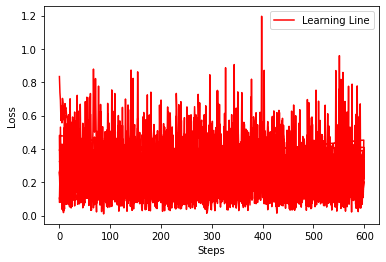

Streaming output truncated to the last 5000 lines.








Train Epoch: 8 [7000/12000 (58%)]	Loss: 0.253652: : 350it [05:03,  1.12it/s]









Train Epoch: 8 [7000/12000 (58%)]	Loss: 0.253652: : 351it [05:03,  1.05it/s]









Train Epoch: 8 [7020/12000 (58%)]	Loss: 0.240480: : 351it [05:04,  1.05it/s]









Train Epoch: 8 [7020/12000 (58%)]	Loss: 0.240480: : 352it [05:04,  1.08it/s]









Train Epoch: 8 [7040/12000 (59%)]	Loss: 0.031907: : 352it [05:05,  1.08it/s]









Train Epoch: 8 [7040/12000 (59%)]	Loss: 0.031907: : 353it [05:05,  1.08it/s]









Train Epoch: 8 [7060/12000 (59%)]	Loss: 0.286719: : 353it [05:06,  1.08it/s]









Train Epoch: 8 [7060/12000 (59%)]	Loss: 0.286719: : 354it [05:06,  1.09it/s]









Train Epoch: 8 [7080/12000 (59%)]	Loss: 0.222831: : 354it [05:07,  1.09it/s]









Train Epoch: 8 [7080/12000 (59%)]	Loss: 0.222831: : 355it [05:07,  1.09it/s]









Train Epoch: 8 [7100/12000 (59%)]	Loss: 0.199179: : 355it [05:07,  1.09it/s]






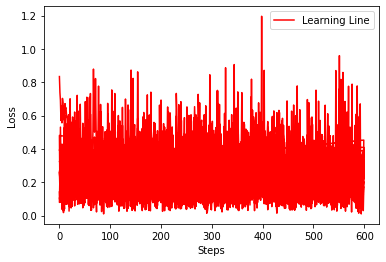

Streaming output truncated to the last 5000 lines.








Train Epoch: 9 [7000/12000 (58%)]	Loss: 0.018323: : 350it [05:03,  1.13it/s]









Train Epoch: 9 [7000/12000 (58%)]	Loss: 0.018323: : 351it [05:03,  1.14it/s]









Train Epoch: 9 [7020/12000 (58%)]	Loss: 0.063813: : 351it [05:04,  1.14it/s]









Train Epoch: 9 [7020/12000 (58%)]	Loss: 0.063813: : 352it [05:04,  1.15it/s]









Train Epoch: 9 [7040/12000 (59%)]	Loss: 0.134910: : 352it [05:05,  1.15it/s]









Train Epoch: 9 [7040/12000 (59%)]	Loss: 0.134910: : 353it [05:05,  1.13it/s]









Train Epoch: 9 [7060/12000 (59%)]	Loss: 0.082783: : 353it [05:06,  1.13it/s]









Train Epoch: 9 [7060/12000 (59%)]	Loss: 0.082783: : 354it [05:06,  1.13it/s]









Train Epoch: 9 [7080/12000 (59%)]	Loss: 0.181701: : 354it [05:07,  1.13it/s]









Train Epoch: 9 [7080/12000 (59%)]	Loss: 0.181701: : 355it [05:07,  1.14it/s]









Train Epoch: 9 [7100/12000 (59%)]	Loss: 0.123970: : 355it [05:08,  1.14it/s]






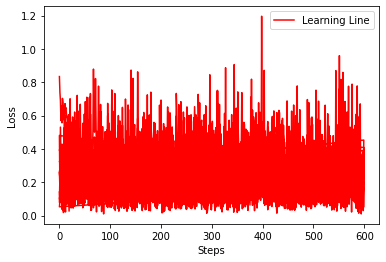

Finished Training


In [108]:
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
T1_VGG16_Model.to(device)

T1_VGG16_Model.train()

T1_ResNet18_lossLst = list()
T1_ResNet18_epochLst = list()
for epoch in range(T1_Vgg16_Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        T1_Vgg16_Optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = T1_VGG16_Model(inputs)                      #----> forward pass
        loss = T1_Vgg16_Criterion(outputs, labels)            #----> compute loss
        loss.backward()                                       #----> backward pass
        T1_Vgg16_Optimizer.step()                             #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset), 100. * i / len(trainloader), loss.item()))
        
        T1_ResNet18_lossLst.append(loss.item())
        T1_ResNet18_epochLst.append(i)
        
    plot_curve(T1_ResNet18_epochLst,T1_ResNet18_lossLst)

    torch.save(T1_VGG16_Model.state_dict(), 'vgg16_FC_Only.pth')

print('Finished Training')

Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


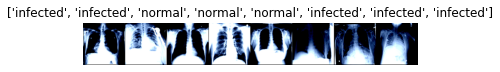

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

Prediction

In [19]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = T1_VGG16_Model(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%10s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%10s' % class_names[labels[j]]
                              for j in range(len(images)))) 

Predicted:    infected     normal   infected     normal     normal     normal     normal     normal     normal     normal     normal     normal     normal     normal     normal     normal     normal     normal     normal     normal
Ground Truth:    infected   infected     normal     normal   infected   infected   infected     normal   infected   infected     normal   infected   infected     normal     normal   infected     normal     normal     normal   infected


In [20]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = T1_VGG16_Model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the '+str(len(test_data))+' test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 1500 test images: 51 %


tensor([[116., 499.],
        [202., 683.]])


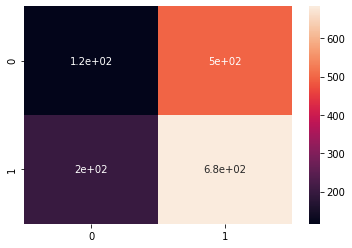

In [21]:
# Confusion Matrix of TEST 

confusion_matrix = torch.zeros(2, 2)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = T1_VGG16_Model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
              
print(confusion_matrix)
sn.heatmap(confusion_matrix, annot=True)

On Vlidation

In [22]:
correct = 0
total = 0
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = T1_VGG16_Model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the '+ str(len(test_data)) +' validation images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 1500 validation images: 54 %


tensor([[133., 482.],
        [212., 673.]])


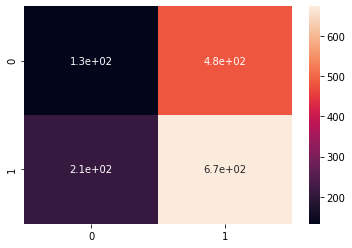

In [23]:
# Confusion Matrix of VALID 

confusion_matrix = torch.zeros(2, 2)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(validloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = T1_VGG16_Model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
              
print(confusion_matrix)
sn.heatmap(confusion_matrix, annot=True)

#Task 2: Fine-tune the CNN and FC layers of the network

###ResNet-18

In [0]:
# Load the pretrained model from pytorch
T2_ResNet18_Model = models.resnet18(pretrained=True)
#print(T1ResNet18)
#print('Output Layer of RESNET-18 : ', T1ResNet18.fc.out_features)

In [0]:
# Remove last layer

T2_ResNet18_Modules = list(T2_ResNet18_Model.children())[:-1]      # delete the last fc layer.
T2_ResNet18_Feature = nn.Sequential(*T2_ResNet18_Modules)

#print(T1ResNet18Feature)

#T1num_features = T1ResNet18.classifier[6].in_features
#T1features = list(T1ResNet18.classifier.children())[:-1] # Remove last layer
#print(T1features)

#T1features = T1ResNet18.Sequential(*list(T1ResNet18.classifier.children())[:-1])

In [0]:
# Un - Freeze training for all layers
for param in T2_ResNet18_Model.parameters():
    param.require_grad = True

In [0]:
# Adding New Layer (FC - Layer)

# Input:25088                     Output:(Last 2 Digits * 10)+100
# Input:(Last 2 Digits * 10)+100  Output:Len(Class) = 2

T2_ResNet18_Modules.extend([nn.Linear(25088, (40 * 10) + 100)])
T2_ResNet18_Modules.extend([nn.Linear((40 * 10) + 100, len(class_names))])

In [0]:
T2_ResNet18_Model.classifier = nn.Sequential(*T2_ResNet18_Modules)
#print(T1ResNet18)

In [0]:
# Loss Function and Optimizer

T2_ResNet18_Epochs = 10 #10
T2_ResNet18_LearningRate = 0.001 # 0.001
T2_ResNet18_Momentum = 0.9
T2_ResNet18_Criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(T2_ResNet18_Model.parameters(), lr = T2_ResNet18_LearningRate, momentum = T2_ResNet18_Momentum)

Train Epoch: 0 [11980/12000 (100%)]	Loss: 0.599893: : 600it [04:55,  2.03it/s]




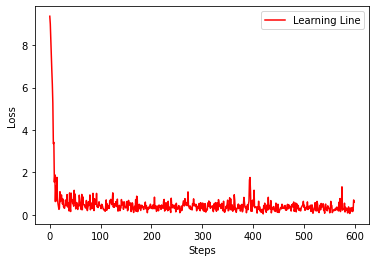

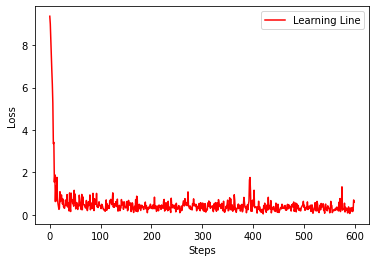

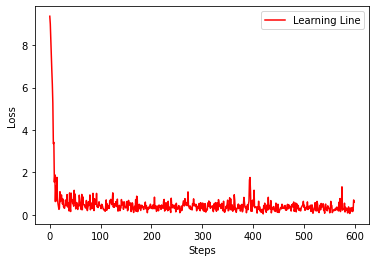

Train Epoch: 1 [11980/12000 (100%)]	Loss: 0.371504: : 600it [04:58,  2.01it/s]




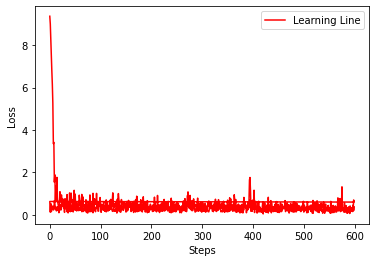

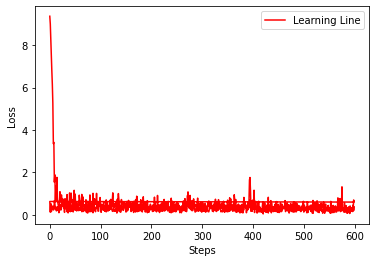

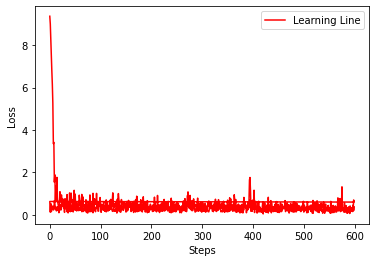

Train Epoch: 2 [11980/12000 (100%)]	Loss: 0.449418: : 600it [05:01,  1.99it/s]




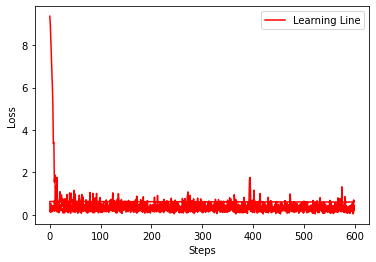

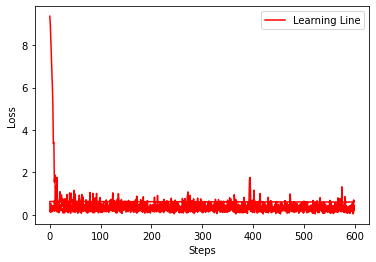

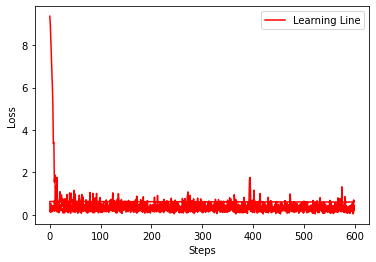

Train Epoch: 3 [11980/12000 (100%)]	Loss: 0.386363: : 600it [04:57,  2.02it/s]




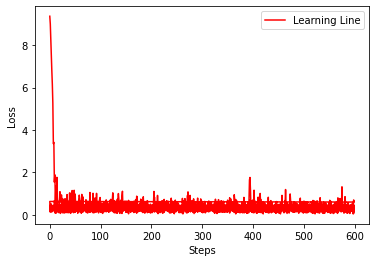

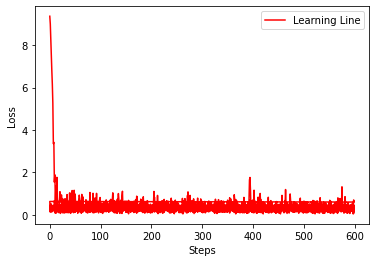

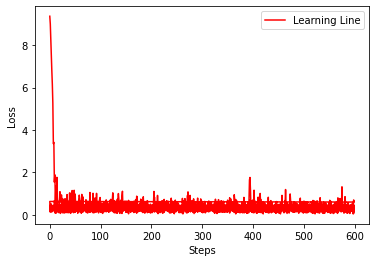

Train Epoch: 4 [11980/12000 (100%)]	Loss: 0.144864: : 600it [04:57,  2.02it/s]




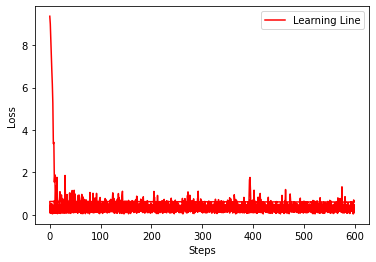

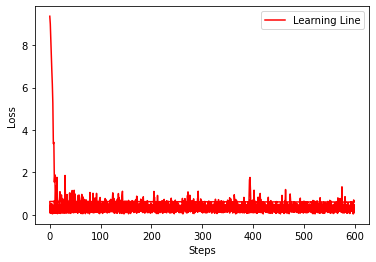

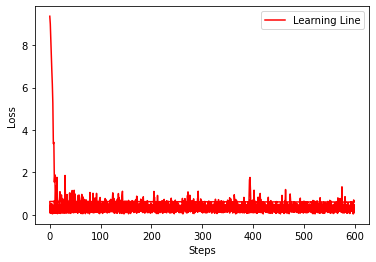

Train Epoch: 5 [11980/12000 (100%)]	Loss: 0.138729: : 600it [04:59,  2.00it/s]




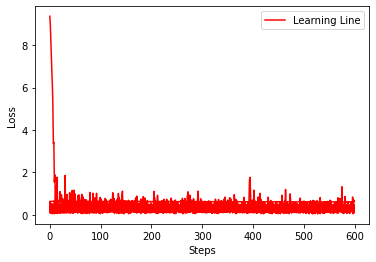

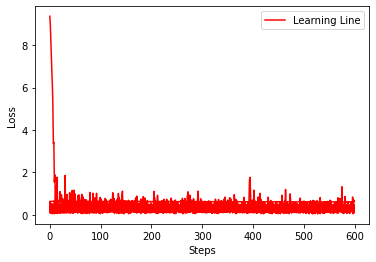

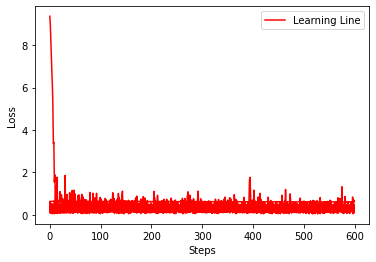

Train Epoch: 6 [11980/12000 (100%)]	Loss: 0.146753: : 600it [05:01,  1.99it/s]




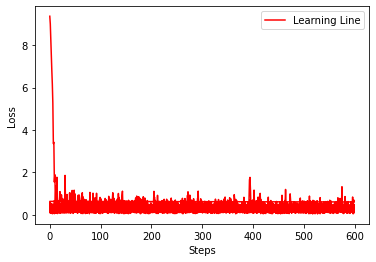

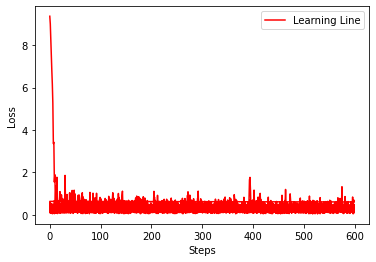

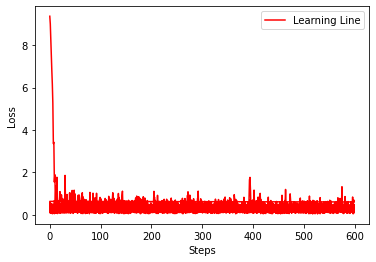

Train Epoch: 7 [11980/12000 (100%)]	Loss: 0.225176: : 600it [05:00,  1.99it/s]




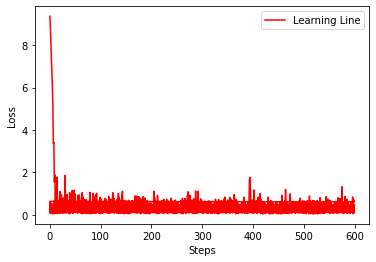

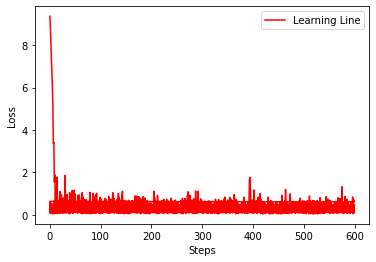

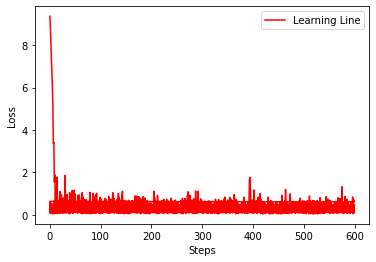

Train Epoch: 8 [11980/12000 (100%)]	Loss: 0.724034: : 600it [05:06,  1.95it/s]




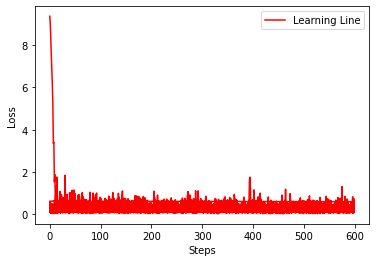

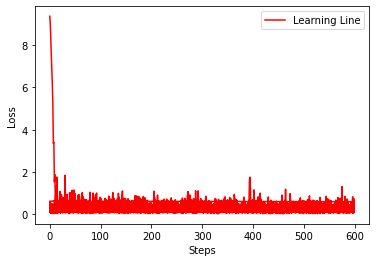

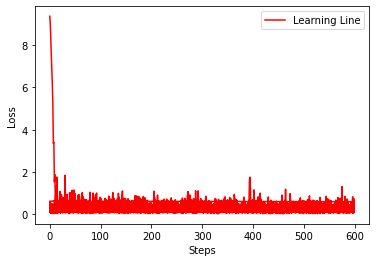

Train Epoch: 9 [11980/12000 (100%)]	Loss: 0.367942: : 600it [05:08,  1.95it/s]




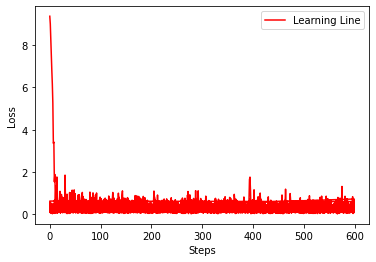

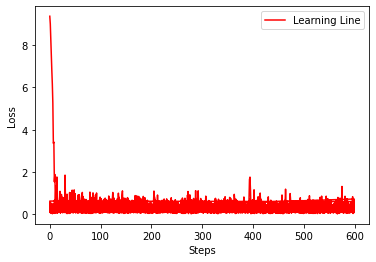

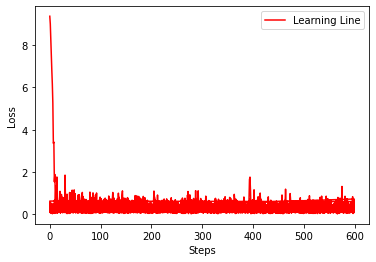

Finished Training
Finished Training
Finished Training


In [25]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
T2_ResNet18_Model.to(device)

T2_ResNet18_Model.train()

T2_ResNet18_lossLst = list()
T2_ResNet18_epochLst = list()
for epoch in range(T2_ResNet18_Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = T2_ResNet18_Model(inputs)            #----> forward pass
        loss = T2_ResNet18_Criterion(outputs, labels)     #----> compute loss
        loss.backward()                         #----> backward pass
        optimizer.step()                        #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader), loss.item()))

        T2_ResNet18_lossLst.append(loss.item())
        T2_ResNet18_epochLst.append(i)

    plot_curve(T2_ResNet18_epochLst,T2_ResNet18_lossLst)  
    
    torch.save(T2_ResNet18_Model.state_dict(), 'res18_entire.pth')

print('Finished Training')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


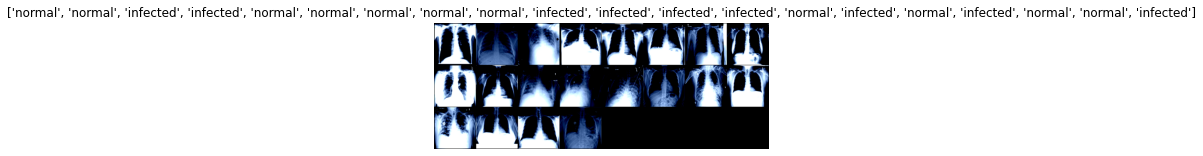

In [33]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [34]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = T2_ResNet18_Model(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images)))) 	

Predicted:  normal normal infected infected normal normal normal normal normal infected infected infected infected normal infected normal infected normal normal infected
Ground Truth:  normal normal infected infected normal normal normal normal normal infected infected infected infected normal infected normal infected normal normal infected


In [35]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = T2_ResNet18_Model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the '+ str(len(test_data)) +' test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 1500 test images: 95 %


tensor([[547.,  68.],
        [ 67., 818.]])


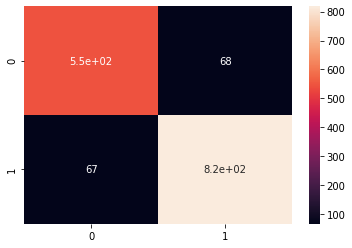

In [36]:
# Confusion Matrix of TEST 

confusion_matrix = torch.zeros(2, 2)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(validloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = T2_ResNet18_Model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
              
print(confusion_matrix)
sn.heatmap(confusion_matrix, annot=True)

On Validation Data

In [37]:
correct = 0
total = 0
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = T2_ResNet18_Model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the '+ str(len(valid_data)) +' validation images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 1500 validation images: 89 %


tensor([[542.,  73.],
        [ 68., 817.]])


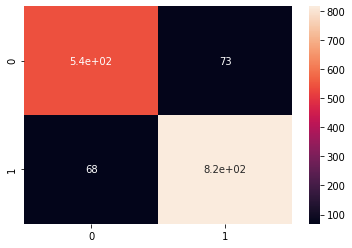

In [38]:
# Confusion Matrix of VALID 

confusion_matrix = torch.zeros(2, 2)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(validloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = T2_ResNet18_Model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
              
print(confusion_matrix)
sn.heatmap(confusion_matrix, annot=True)

###VGG-16

In [39]:
# Load the pretrained model from pytorch
T2_VGG16_Model = models.vgg16(pretrained=True)
#print(T2_VGG16_Model)
print('Output Layer of VGG-16 : ', T2_VGG16_Model.classifier[6].out_features) 

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



Output Layer of VGG-16 :  1000


In [40]:
# Remove last layer
T2_VGG16_Features = list(T2_VGG16_Model.classifier.children())[:-1] # Remove last layer
print(T2_VGG16_Features)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False)]


In [0]:
# Freeze training for all layers
for param in T2_VGG16_Model.features.parameters():
    param.require_grad = True

In [0]:
# Adding New Layer (Linear - FC Layer)

# Input:25088                     Output:(Last 2 Digits * 10)+100
# Input:(Last 2 Digits * 10)+100  Output:Len(Class) = 2

T2_VGG16_Features.extend([nn.Linear(T2_VGG16_Model.classifier[6].in_features, (40 * 10) + 100)])
T2_VGG16_Features.extend([nn.Linear((40 * 10) + 100, len(class_names))])

In [0]:
T2_VGG16_Model.classifier = nn.Sequential(*T2_VGG16_Features)
#print(T2_VGG16_Model)

In [0]:
# Loss Function and Optimizer

T2_Vgg16_Epochs = 5 #10
T2_Vgg16_LearningRate = 0.001 # 0.001
T2_Vgg16_Momentum = 0.9
T2_Vgg16_Criterion = nn.CrossEntropyLoss()

T2_Vgg16_Optimizer = optim.SGD(T2_VGG16_Model.parameters(), lr = T2_Vgg16_LearningRate, momentum = T2_Vgg16_Momentum)

Train Epoch: 0 [11980/12000 (100%)]	Loss: 0.631493: : 600it [08:37,  1.16it/s]


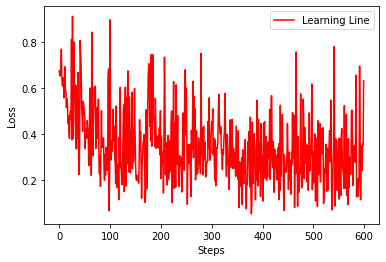

Train Epoch: 1 [11980/12000 (100%)]	Loss: 0.282847: : 600it [08:41,  1.15it/s]


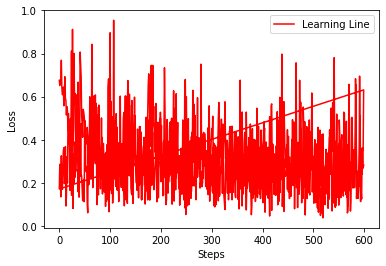

Train Epoch: 2 [11980/12000 (100%)]	Loss: 0.228371: : 600it [08:38,  1.16it/s]


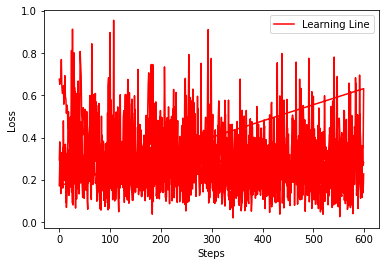

Train Epoch: 3 [11980/12000 (100%)]	Loss: 0.215091: : 600it [08:39,  1.15it/s]


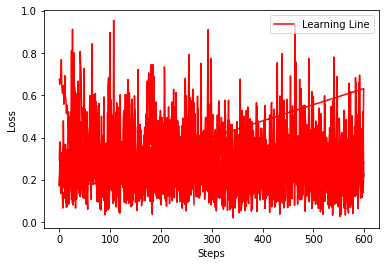

Train Epoch: 4 [11980/12000 (100%)]	Loss: 0.134994: : 600it [08:39,  1.16it/s]


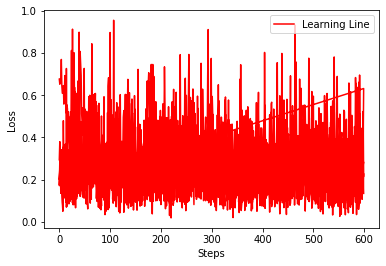

Finished Training


In [45]:
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
T2_VGG16_Model.to(device)

T2_VGG16_Model.train()

T2_ResNet18_lossLst = list()
T2_ResNet18_epochLst = list()

for epoch in range(T2_Vgg16_Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        T2_Vgg16_Optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = T2_VGG16_Model(inputs)                      #----> forward pass
        loss = T2_Vgg16_Criterion(outputs, labels)            #----> compute loss
        loss.backward()                                       #----> backward pass
        T2_Vgg16_Optimizer.step()                             #----> weights update

        # print statistics
        running_loss += loss.item()

        pbar.set_description('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset), 100. * i / len(trainloader), loss.item()))

        T2_ResNet18_lossLst.append(loss.item())
        T2_ResNet18_epochLst.append(i)

    plot_curve(T2_ResNet18_epochLst,T2_ResNet18_lossLst)  

    torch.save(T2_VGG16_Model.state_dict(), 'vgg16_entire.pth')

print('Finished Training')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


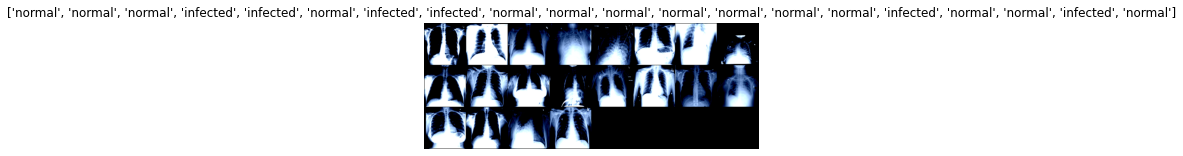

In [46]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [47]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = T2_VGG16_Model(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images)))) 

Predicted:  normal normal normal infected infected normal infected infected normal normal normal normal normal normal normal infected normal normal infected normal
Ground Truth:  normal normal normal infected infected normal infected infected normal normal normal normal normal normal normal infected normal normal infected normal


In [48]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = T2_VGG16_Model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the '+ str(len(test_data)) +' test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 1500 test images: 96 %


tensor([[505., 110.],
        [ 21., 864.]])


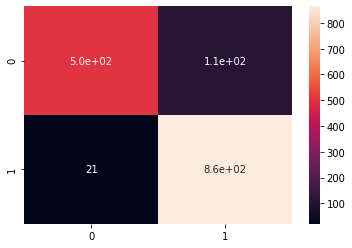

In [49]:
# Confusion Matrix of TEST 

confusion_matrix = torch.zeros(2, 2)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(validloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = T2_VGG16_Model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
              
print(confusion_matrix)
sn.heatmap(confusion_matrix, annot=True)

On Validation Data 

In [50]:
correct = 0
total = 0
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = T2_VGG16_Model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the '+ str(len(valid_data)) +' validation images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 1500 validation images: 91 %


tensor([[509., 106.],
        [ 22., 863.]])


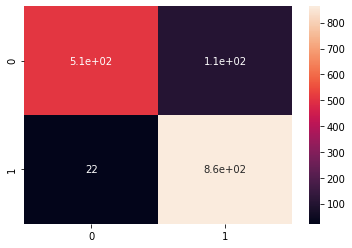

In [51]:
# Confusion Matrix of VALID 

confusion_matrix = torch.zeros(2, 2)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(validloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = T2_VGG16_Model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
              
print(confusion_matrix)
sn.heatmap(confusion_matrix, annot=True)

Loss Curves All

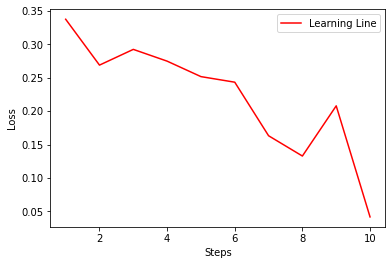

In [52]:
# TASK 1 RESNET 18

plt.plot(
    [1,2,3,4,5,6,7,8,9,10], 
    [0.337713,0.269025,0.292583,0.274965,0.251807,0.243448,0.163272,0.132886,0.208028,0.041724], 
    color='red', label='Learning Line')
plt.legend()
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

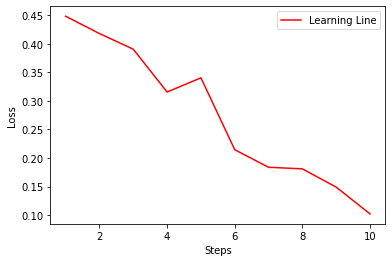

In [53]:
# TASK 1 VGG 16

plt.plot(
    [1,2,3,4,5,6,7,8,9,10], 
    [0.448268,0.417950,0.390514,0.315549,0.340445,0.214603,0.183846,0.181046,0.149088,0.102157], 
    color='red', label='Learning Line')
plt.legend()
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

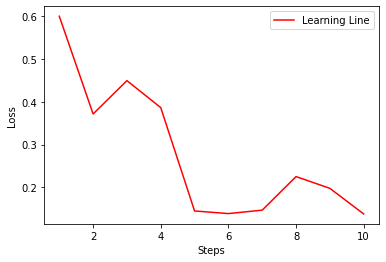

In [54]:
# TASK 2 RESNET 18

plt.plot(
    [1,2,3,4,5,6,7,8,9,10], 
    [0.599893,0.371504,0.449418,0.386363,0.144864,0.138729,0.146753,0.225176,0.197753,0.137942], 
    color='red', label='Learning Line')
plt.legend()
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

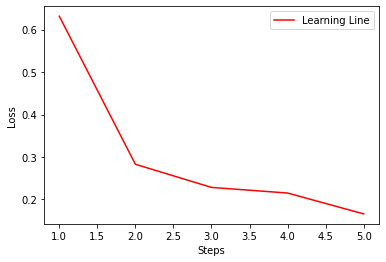

In [55]:
# TASK 2 VGG 16

plt.plot(
    [1,2,3,4,5], 
    [0.631493,0.282847,0.228371,0.215091,0.165923], 
    color='red', label='Learning Line')
plt.legend()
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()